# Train a Bounding Box Model

Now we use the bounding boxes we drew for some of the images in the '2 - Butterfly Innotater' notebook to train a bounding box model. This will predict how to draw a minimal rectangle around the butterfly located within the image. If that makes good predictions, we can 'crop and zoom in' on the butterfly itself, making a new set of images that have more accurate photos of the butteflies (with much less background). We will then see if training a _classification_ model on those new images gives better performance than the model we trained in the previous notebook '3 - Basic Train'.

In practice, we could then combine the models to build a working classification service for new images. The image would be run through the bounding box model to zoom in, and then the zoomed-in image run through the final classifier model.

In [2]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress

torch.backends.cudnn.benchmark = True
fastprogress.MAX_COLS = 80

n_gpus = num_distrib() or 1
workers = min(8, num_cpus()//n_gpus)

size = 256 # Image size width and height
bs = 32 # Batch size

if torch.cuda.is_available():
    torch.cuda.set_device(0)

np.random.seed(13)

We need to maintain two copies of the Pandas DataFrame (CSV file). `full_df` will contain all images (except those flagged as `exclude` based on our manual labelling through the Innotater, where we marked some images which shouldn't be in the dataset at all). Then `df` is a cut-down version of `full_df` containing only images where we have a known bounding box (drawn manually with the Innotater in notebook 2).

The bulk of this notebook trains the bounding box model on the `df` data only, and then in the final section we run the bounding box model on every image in our dataset (i.e. on all of `full_df`) so we can generate a new set of zoomed-in images.

In [78]:
BUTTERFLIES_BBOXES_FILEPATH = Path('./butterflies_bboxes.csv')

IMAGE_FOLDER = Path('./butterfly_medium_images')

full_df = pd.read_csv(BUTTERFLIES_BBOXES_FILEPATH)
full_df = full_df[full_df['exclude'] == 0]
full_df = full_df.reset_index(drop=True)

To train bounding box models, assume that any row with a non-zero 'w' (width) contains a valid bounding box. The default 'bounding box' for images where we haven't drawn bounding boxes is 0,0,0,0.

In [79]:
df = full_df[full_df['w'] != 0]
df = df.reset_index(drop=True)

In [80]:
# Take first 80% of each class as training data. 
# Prepare a list of indexes that have been selected for the validation set.

train_class_count = int(0.8*df['class'].value_counts().values.min())

valid_idxs = []
for c in df['class'].unique(): # Step through 'gatekeeper_butterfly' and 'meadow_brown_butterfly'
    valid_idxs.extend(df[df['class'] == c].index.values[train_class_count:])


In [81]:
# fast.ai v1.0.50 (which I'm using here) doesn't seem to have reliable Bounding Box LabelList 
# so I've built my own. You may be able to use native fast.ai blasses only in the future.

from fastai.vision.data import _get_size
class BBoxLabelList(PointsLabelList):

    def get(self, i):
        o = ItemList.get(self,i) # Grandparent class
        return ImageBBox(FlowField(_get_size(self.x,i), o), scale=True)

    def reconstruct(self, t, x):
        if t.numpy().shape == (2,2):
            t = t.view(1,4) # Expecting flattened
        return ImageBBox.create(*x.size,t, scale=False)

class BBoxItemList(ImageList):
    "`ItemList` for `Image` to `ImageBBox` tasks."
    _label_cls,_square_show_res = BBoxLabelList,False

In [82]:
bblist = BBoxItemList.from_df(df, path=IMAGE_FOLDER, folder='', cols='filename') # use filename col in DataFrame

In [83]:
# Just in case Flickr gives you different size images to the ones I obtained, I saved
# the image sizes in butterflies_bboxes.csv, so we can adjust bbox sizes relatively.
# This whole cell will not be relevant if you searched for your own images and 
# annotated them yourself.
orig_image_sizes = None
if 'orig_file_width' in df and 'orig_file_height' in df:
    orig_image_sizes = df[['orig_file_height','orig_file_width']].values

In [84]:
# Map filenames to Tensors containing Bounding Box data

filename_to_index = dict([(fn,i) for i,fn in enumerate(df['filename'])])

def get_y_func(o):
    ind = filename_to_index[Path(o).name]
    x,y,w,h = df.loc[ind][['x','y','w','h']].values.astype(np.int64)
    
    if orig_image_sizes is not None:
        # This adjustment is only due to possible Flickr size differences
        # You don't need this code if you found your own images
        # and annotated them directly to their relative size.
        act_h, act_w = list(_get_size(bblist,ind))
        orig_h, orig_w = orig_image_sizes[ind]
        if act_w != orig_w:
            x = int(x * act_w / orig_w)
            w = int(w * act_w / orig_w)
        if act_h != orig_h:
            y = int(y * act_h / orig_h)
            h = int(h * act_h / orig_h)
    
    return Tensor([[float(y),float(x)],[float(y+h),float(x)],[float(y+h),float(x+w)],[float(y),float(x+w)]])


In [85]:
bblist = (bblist.split_by_idx(valid_idxs) # Split into train/validation set based on validation ids given
                .label_from_func(get_y_func)) # Labels are bounding boxes, obtained via specified func

In [86]:
# Some sensible defaults for training data augmentation (tfms[0]), 
# just crop/resize for the validation set (tfms[1])
tfms = get_transforms(); tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, res

In [87]:
data = (bblist.transform(tfms, tfm_y=True, remove_out=False, size=(size,size))
        # Apply augmentation transforms
        # tfm_y=True means that the y-values (BBoxes) also need shifting by
        # corresponding amounts, e.g. if the image is roating, the BBox co-ords must rotate too.
        # remove_out=False means all BBox points must remain present even if they end up
        # outside the image boundaries.
        .databunch(bs=bs, num_workers=workers)) # Turn into convenient batch-loader

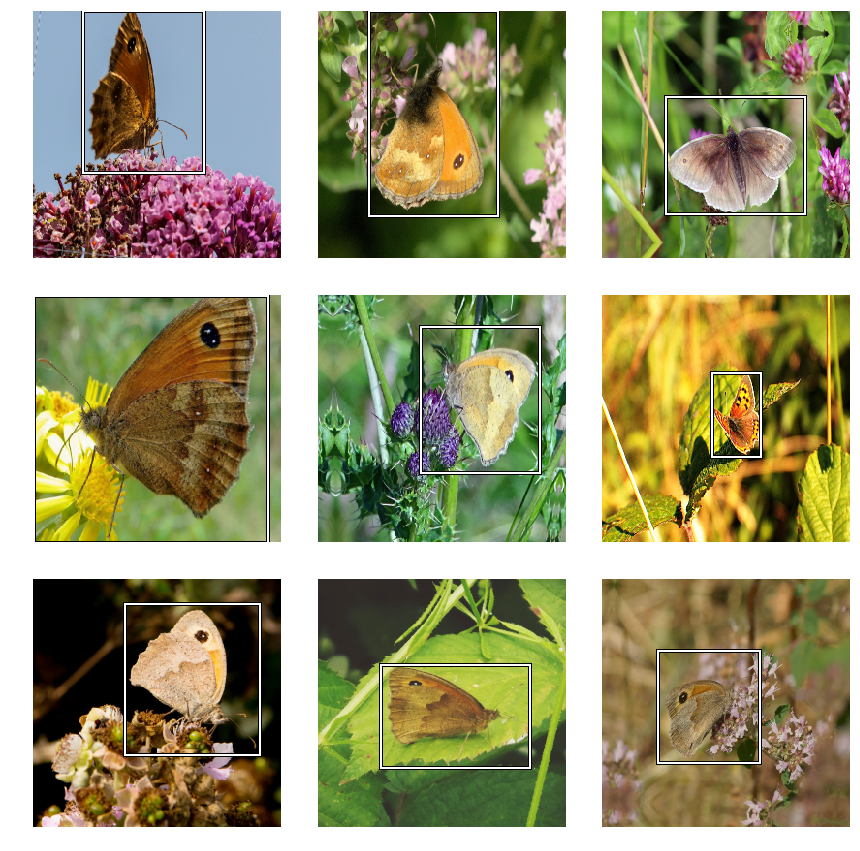

In [88]:
data.show_batch(rows=3) # Show some training data including our manual bounding boxes

## Set up Training for Bounding Box model

In [89]:
# Set up training params

lr = 1e-5 # Learning rate
alpha = 0.9 # Alpha
mom = 0.9 # Momentum
eps = 1e-7 # epsilon

m = models.resnet50(pretrained=True)

# Set a new custom head - the 4 outputs are x,y,w,h of the bounding box
m.fc = nn.Sequential(Flatten(), nn.Linear(2048,4))

# We know from inspecting `m` previously that the last fully-connected layer
# is called `fc` so we just replace it directly.

In [90]:
# Loss function is L1 distance measurement
class L1LossFlat(nn.L1Loss):
    "Mean Absolute Error Loss"
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))
    
# Same calulation basically, but to be used as displayable metric
def detn_l1(input, target):
    return F.l1_loss(input,target).data


In [91]:
# Use Adam optimiser
opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)

loss_func = L1LossFlat()

learn = (Learner(data, m,
             metrics=[detn_l1], 
             opt_func=opt_func,
             loss_func = loss_func)
        )

In [76]:
# Find a suitable learning rate
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


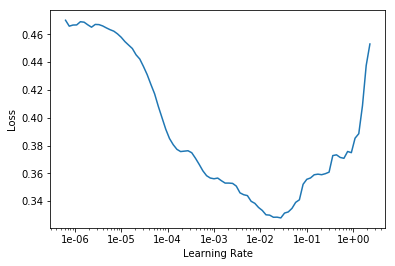

In [77]:
learn.recorder.plot()

In [92]:
# Start training

lr = 8e-5

learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,detn_l1,time
0,0.719641,0.714603,0.716380,00:12
1,0.677347,0.537869,0.544408,00:08
2,0.584631,0.287709,0.327417,00:08
3,0.477779,0.247270,0.300832,00:08
4,0.410393,0.230839,0.296667,00:08
5,0.362037,0.203847,0.279495,00:08
6,0.321154,0.193680,0.276424,00:08
7,0.290343,0.177630,0.266258,00:08
8,0.265018,0.168549,0.259121,00:08
9,0.244933,0.164395,0.254977,00:08


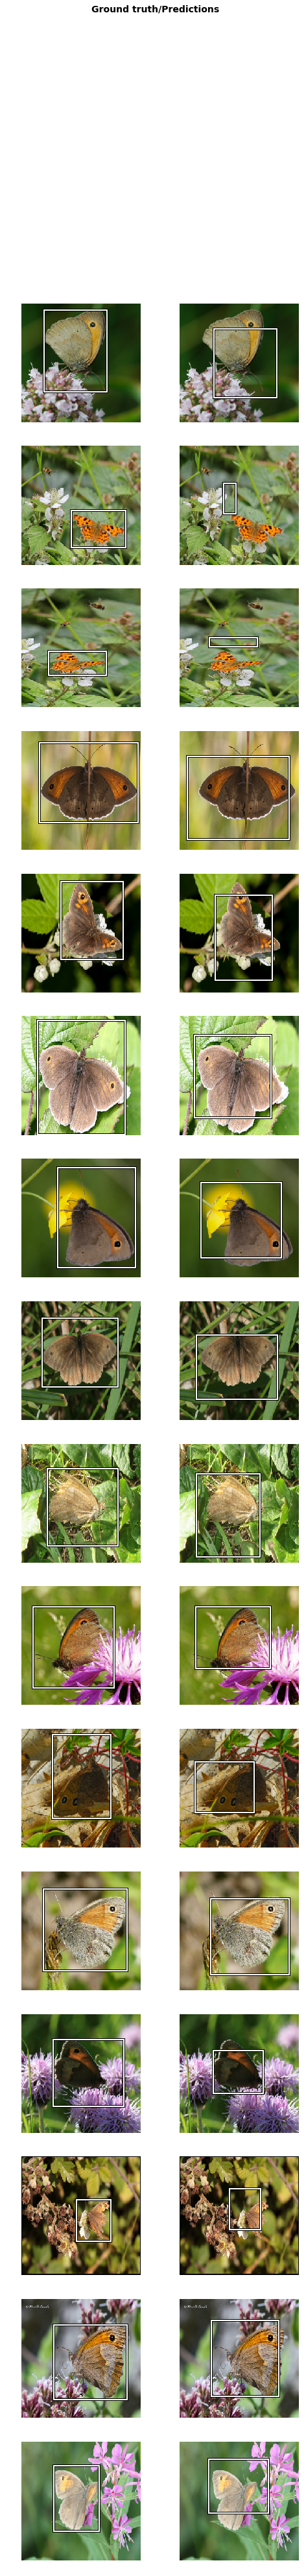

In [93]:
# How is model performing on our validation set so far?
learn.show_results(ds_type=DatasetType.Valid, rows=16)

In [ ]:
learn.save('bbox-frozen-1')

In [ ]:
#learn.load('bbox-frozen-1');

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-5

In [ ]:
learn.fit_one_cycle(5, lr)

In [ ]:
learn.show_results(ds_type=DatasetType.Valid, rows=16)

In [ ]:
learn.save('bbox-frozen-2')

In [ ]:
#learn.load('bbox-frozen-2')

In [ ]:
learn.fit_one_cycle(20, lr/2)

In [ ]:
learn.show_results(ds_type=DatasetType.Valid, rows=16)

## Generate cropped/zoomed versions

Based on bounding box predictions, crop/zoom ALL images so we have a new set of images showing (hopefully) just the butterfly close up. We will use these in the next notebook to train a new classification-only model.

In [ ]:
m.eval()

IMAGE_FOLDER_ZOOMED = IMAGE_FOLDER / 'zoomed'

IMAGE_FOLDER_ZOOMED.mkdir(exist_ok=True)

padding = 25 # extra pixels to take around bounding box predictions, just in case

for row in full_df.iterrows():
    fn = str(row[1]['filename'])
    
    im = open_image(IMAGE_FOLDER/fn)
    
    print(f'Processing {fn} of {im.shape}')
    
    imr = im.resize(size)

    bbox = m(imr.data[None].to('cuda'))
    bb = bbox.data.to('cpu').numpy()
    
    y0,x0,y1,x1 = ((size * bb + size)/2).astype('int')[0]
    
    x0 = max(x0-padding,0)
    y0 = max(y0-padding,0)
    x1 = min(x1+padding,size-1)
    y1 = min(y1+padding,size-1)
    if x1 > x0 and y1 > y0:
        print(f'Resizing to ({x0},{y0},{x1},{y1})')
        imr.pixel(lambda p: p[:,y0:y1,x0:x1])

    imr.save(IMAGE_FOLDER_ZOOMED/fn)
